# Github code for PE and Complexity

In [1]:
''' This module has essential functions supporting
fast and effective computation of permutation entropy and
its different variations.'''
import numpy as np
import math


def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts)

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :]
    permutation = np.argsort(partition)
    idx = _hash(permutation)

    counts = np.zeros(math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * math.factorial(n-1) + _hash(x[:, 1:])


def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

def weighted_ordinal_patterns(ts, embdim, embdelay):
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts)

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :]
    xm = np.mean(partition, axis=1)
    weight = np.mean((partition - xm[:, None])**2, axis=1)
    permutation = np.argsort(partition)
    idx = _hash(permutation)
    counts = np.zeros(math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = sum(weight[i == idx])

    return list(counts[counts != 0])

# Import libraries

In [2]:
import numpy as np
# from google.colab import files
import io
import zipfile
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# Download and unzip data

In [3]:
!wget https://uni-siegen.sciebo.de/s/HGdUkoNlW1Ub0Gx/download -O WESAD.zip

with zipfile.ZipFile('WESAD.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

zsh:1: command not found: wget


# Utility functions

In [4]:
state_labels = {1: 'Baseline', 2: 'Stress', 3: 'Amusement', 4: 'Meditation'}

In [5]:
def load_data(subject_id):
    """
    Loading data
    Input: subject_id - int - id of subject to load data.
    Output: data - dict - sync data for the subject.
    """
    with open(f'data/WESAD/S{subject_id}/S{subject_id}.pkl', 'rb') as f:
        data = pickle.load(f, encoding='latin1')
        f.close()
    return data

In [6]:
def extract_samples(data, signal_length=4096):
    """
    Extract samples
    Input: data - dict - sync data for the subject.
    Output: labeled_dict - dict - dict with samples of length 4096 and seperated into set of label (state).
    """
    total_samples = len(data["label"])
    labeled_dict = defaultdict(list)
    
    for i in range(0, total_samples-signal_length, signal_length):
        out = defaultdict(list)
        for k in data["signal"]["chest"].keys():
            out_data = data["signal"]["chest"][k][i:i+signal_length]
            out[k].append(out_data)
    
        label = np.unique(data["label"][i:i+signal_length])
        labeled_dict[tuple(label)].append(out)
    return labeled_dict

In [7]:
def find_pe_complexity(sequence, embdim=4, embdelay=1):
    """
    Compute PE and Complexity
    Input: 
        sequence - list - sample of length 4096.
        embdim - int - embedding dimension for ordinal patterns.
        embdelay - int - embedding delay for ordinal patterns.
    Output: 
        pe_result - float - permutation entropy of the sequence.
        complexity_result - float - complexity of the sequence.
    """
    ord_patt = ordinal_patterns(sequence, embdim, embdelay)
    
    pe_result = p_entropy(ord_patt)
    complexity_result = complexity(ord_patt)
    
    return pe_result, complexity_result

In [8]:
def choose_samples_and_plot(labeled_dict, subject_id, signal_length=4096):
    """
    Choose continuous 10 random samples and plot.
    Input: 
        labeled_dict - dict - dict with samples of length 4096 and seperated into set of label (state).
        subject_id - int - id of subject.
    Output: samples_choosen - dict - dict with each random choosen sample index.
    """
    samples_choosen = dict()
    
    for choosen_label in range(1, 5):
        out = labeled_dict[(choosen_label,)]
        plt.figure(figsize=(10, 10))
    
        random_samples_choosen = random.sample(range(0, len(out)), 10)
        samples_choosen[choosen_label] = random_samples_choosen
        for i, choose_sample in enumerate(random_samples_choosen):
            for key in out[i].keys():
                for j in range(out[i][key][0][i].shape[-1]):
                    
                    sns.lineplot(x= range(signal_length*i+1, signal_length*i + (signal_length+1)), 
                                 y=out[choose_sample][key][0][:,j], label=f"{key}_{j}", legend=False)
    
        plt.title(f"Plotting samples for label: {state_labels[choosen_label]}\nSubject ID: {subject_id}")
    return samples_choosen

In [9]:
def find_pe_complexity_for_all_samples(labeled_dict, samples_choosen):
    """
    Compute PE and complexity of all the samples.
    Input: 
        labeled_dict - dict - dict with samples of length 4096 and seperated into set of label (state).
        samples_choosen - dict - dict with each random choosen sample index.
    Output: 
        pe_dict - dict - PE values for each moduality.
        complexity_dict - dict - complexity values for each moduality.
    """
    pe_dict = defaultdict(lambda: defaultdict(list))
    complexity_dict = defaultdict(lambda: defaultdict(list))
    
    
    for label in range(1, 5):
      out = labeled_dict[(label,)]
    
      for _, i in enumerate(samples_choosen[label]):
        for key in out[i].keys():
    
          n_cols = out[i][key][0].shape[-1]
    
          for j in range(n_cols):
            sequence = out[i][key][0][:,j]
            pe_result, complexity_result = find_pe_complexity(sequence)
    
            n_key = key
            if n_cols > 1:
              n_key = f"{key}_{j}"
            pe_dict[label][n_key].append(pe_result)
            complexity_dict[label][n_key].append(complexity_result)
    return pe_dict, complexity_dict

In [10]:
def plot_pe_complexity(pe_dict, complexity_dict, state_labels, subject_id):
    """
    Make plot of all the samples and modulatiies.
    Input: 
        pe_dict - dict - PE values for each moduality.
        complexity_dict - dict - complexity values for each moduality.
        state_labels - dict - mapping for state labels.
        subject_id - int - id of subject
    Output: None
    """
    
    mods = ['ACC_0', 'ACC_1', 'ACC_2', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
    
    for mod_choosen in mods:
      plt.figure()
      for state_choosen in state_labels.keys():
    
        pe_values = pe_dict[state_choosen][mod_choosen]
        complexity_values = complexity_dict[state_choosen][mod_choosen]
        state = state_labels[state_choosen]
        plt.scatter(pe_values, complexity_values, label=state, alpha=0.7)
    
      plt.xlabel('Permutation Entropy')
      plt.ylabel('Complexity')
      plt.title(f'Entropy vs Complexity for {mod_choosen} and subject_id {subject_id}')
      plt.legend()
      plt.show()

In [11]:
def plot_pe_complexity(pe_dict, complexity_dict, state_labels, subject_id):
    """
    Make plot of all the samples and modulatiies.
    Input: 
        pe_dict - dict - PE values for each moduality.
        complexity_dict - dict - complexity values for each moduality.
        state_labels - dict - mapping for state labels.
        subject_id - int - id of subject
    Output: None
    """
    
    mods = ['ACC_0', 'ACC_1', 'ACC_2', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
    num_mods = len(mods)
    cols = 3
    rows = 3
    
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))  # Adjust figure size
    
    axes = axes.flatten() if num_mods > 1 else [axes]
    
    for i, mod_choosen in enumerate(mods):
        ax = axes[i]
        for state_choosen in state_labels.keys():
            pe_values = pe_dict[state_choosen][mod_choosen]
            complexity_values = complexity_dict[state_choosen][mod_choosen]
            state = state_labels[state_choosen]
            ax.scatter(pe_values, complexity_values, label=state, alpha=0.7)
        
        ax.set_title(f'{mod_choosen} for subject_id {subject_id}')
        ax.set_xlabel("Permutation Entropy")
        ax.set_xlabel("Complexity")
        ax.tick_params(axis="x", rotation=90) 
        ax.legend()
    
    for i in range(num_mods, len(axes)):
        fig.delaxes(axes[i])
    fig.suptitle("Entropy vs Complexity")
    plt.tight_layout()
    plt.show()

# Process multiple subject ids

Processing subject_id 2


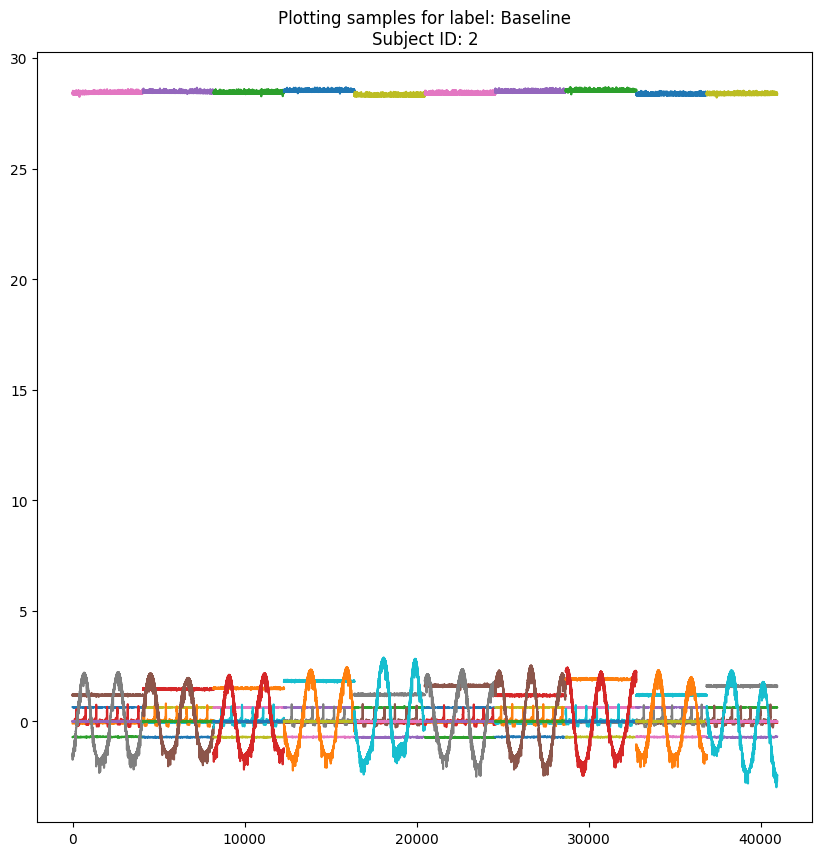

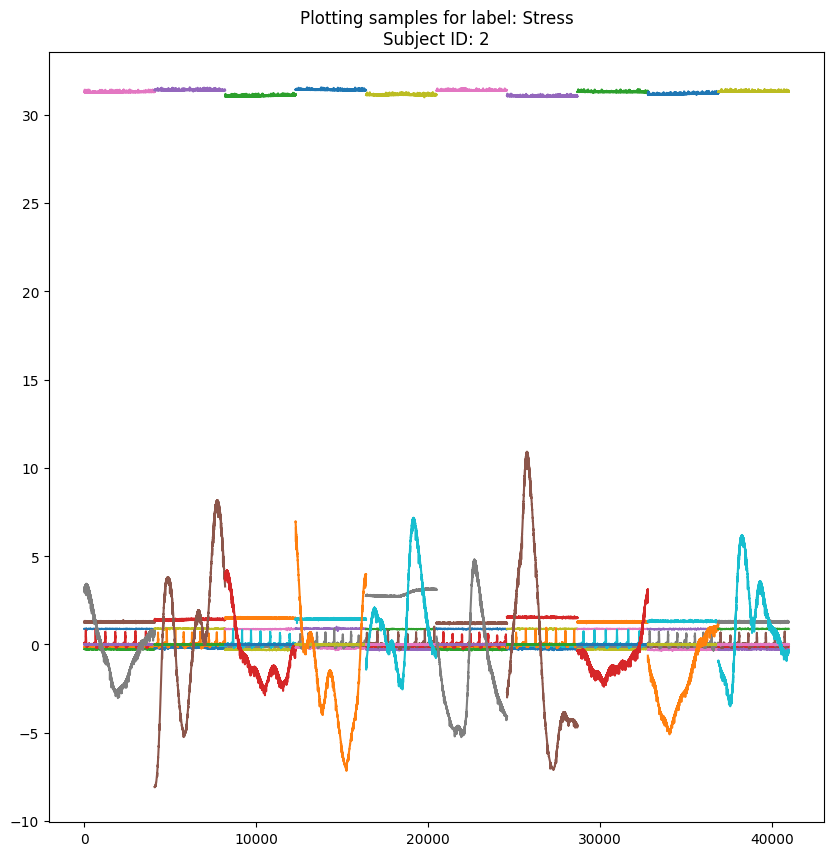

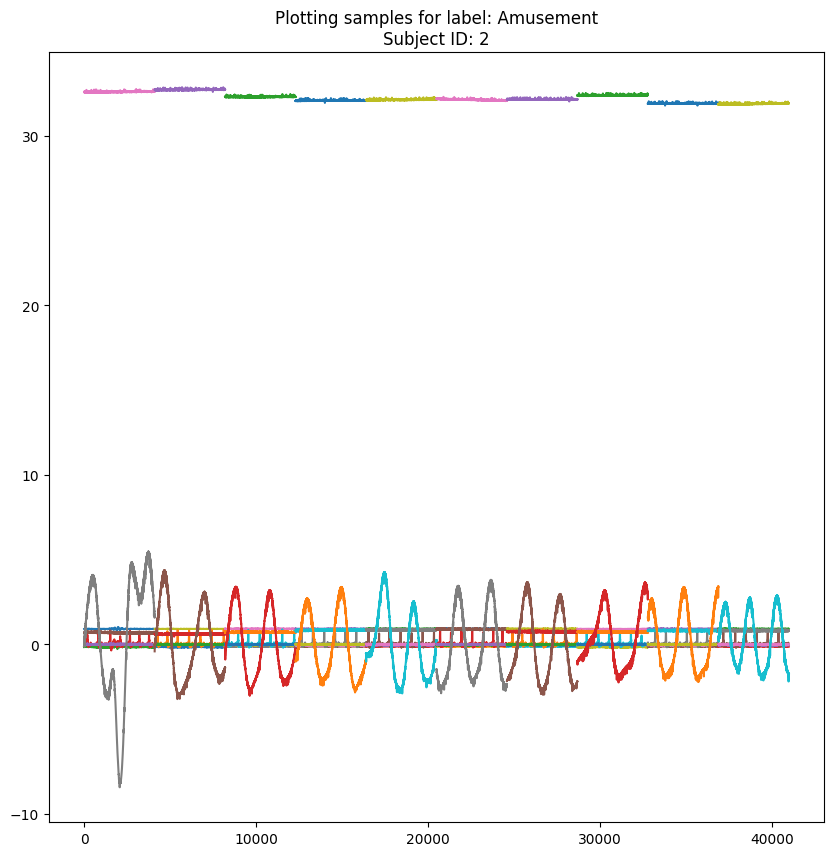

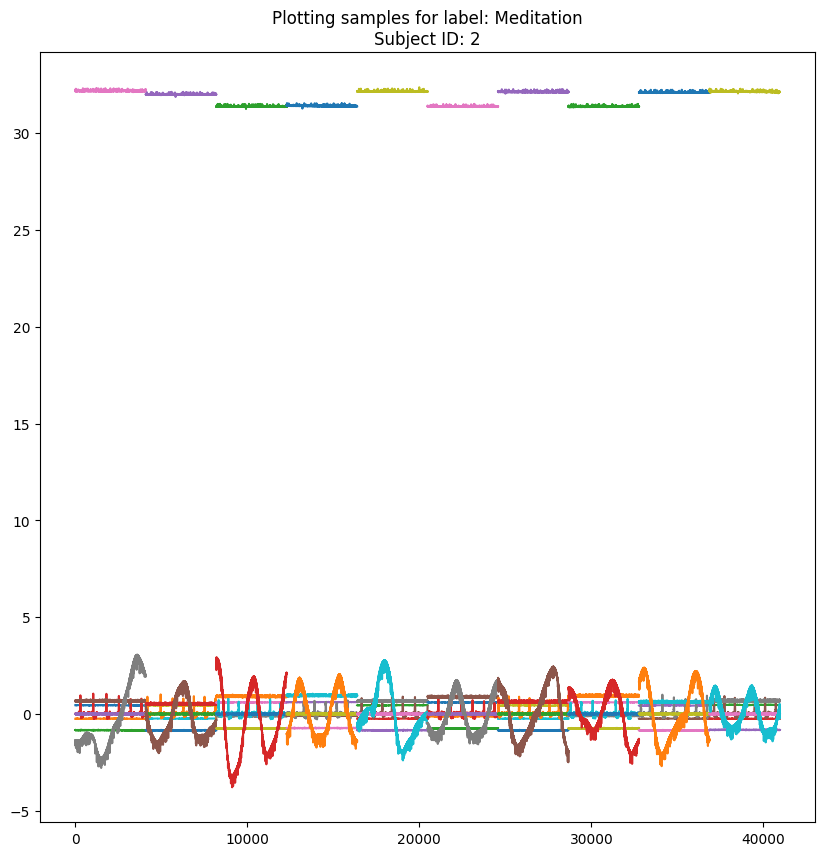

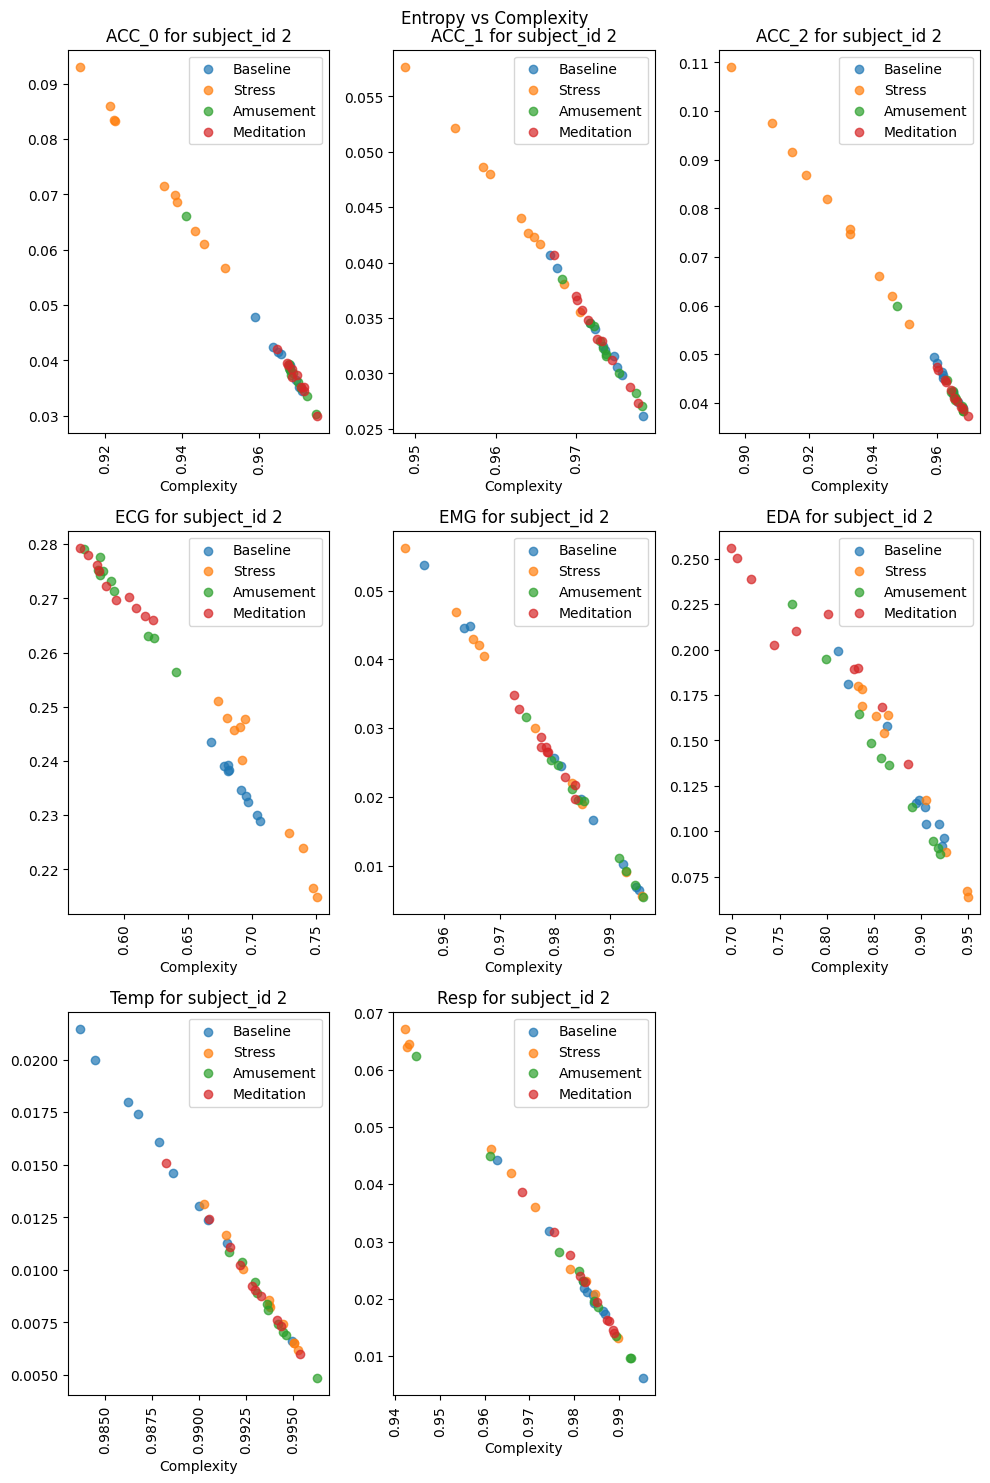

Processing subject_id 4


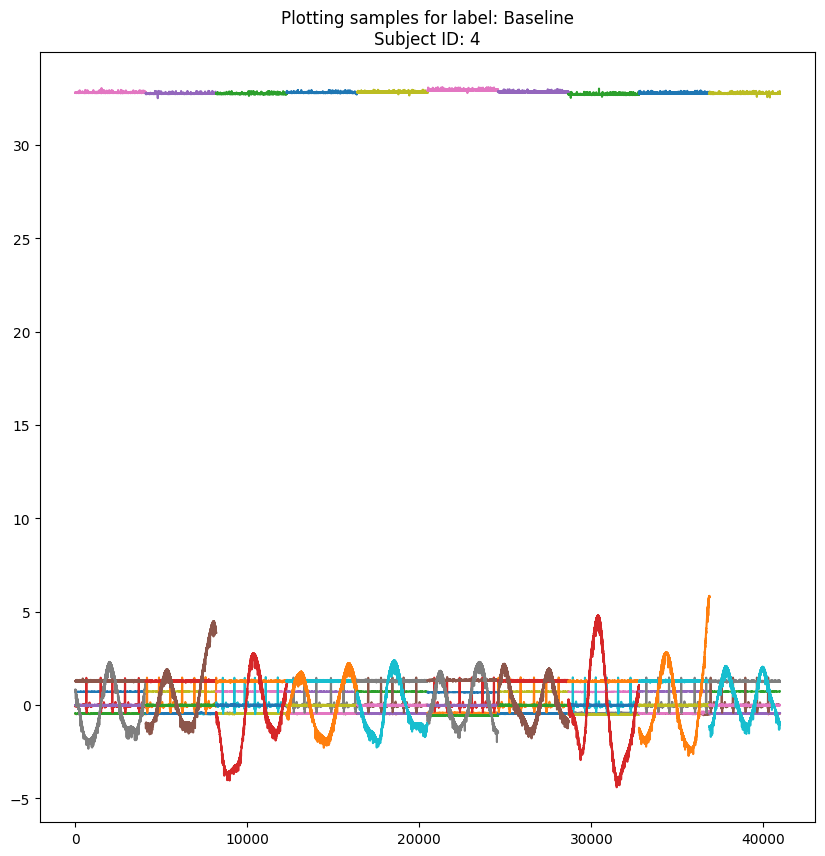

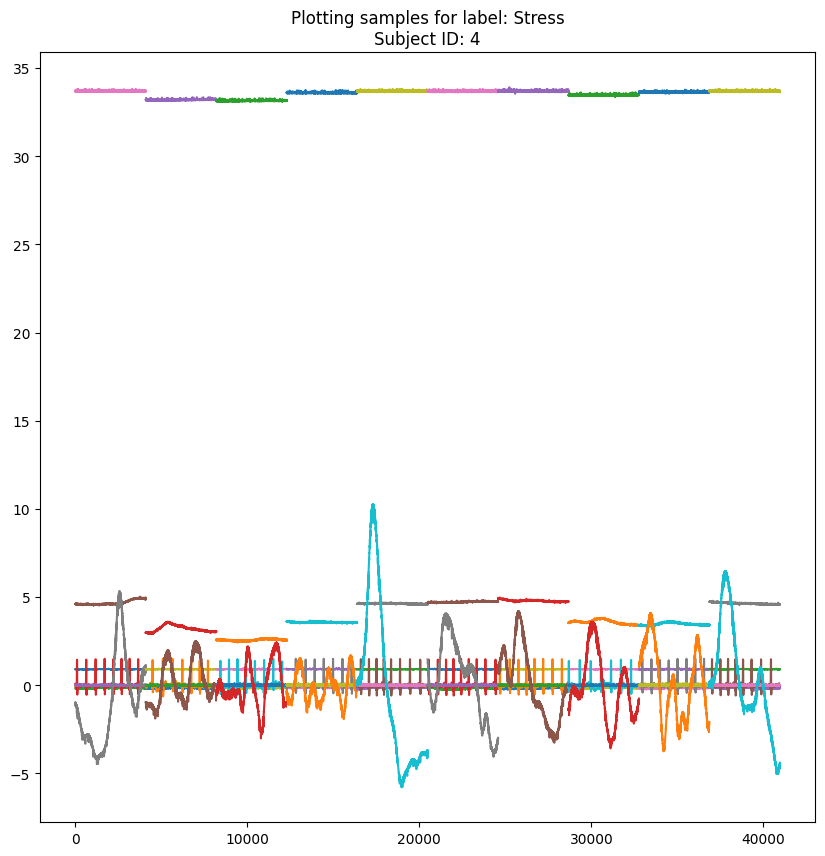

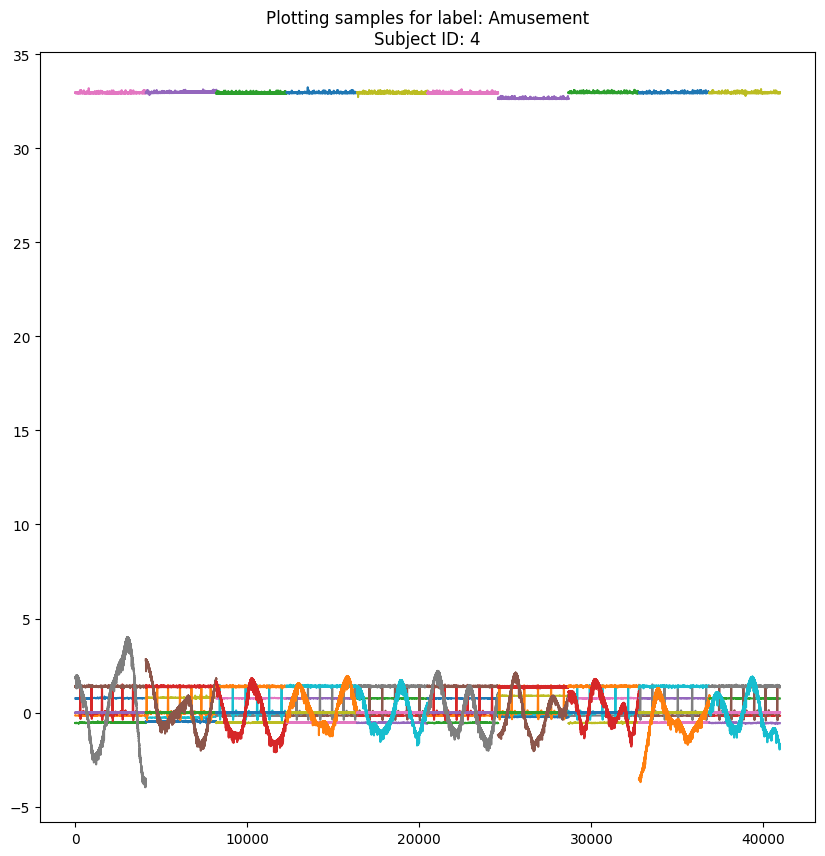

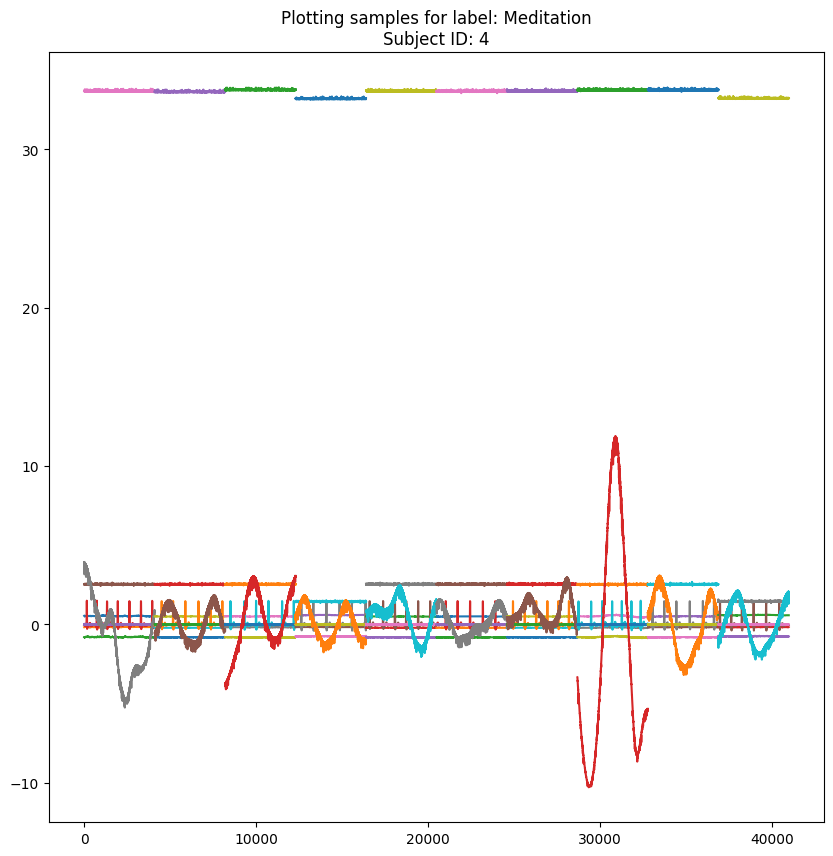

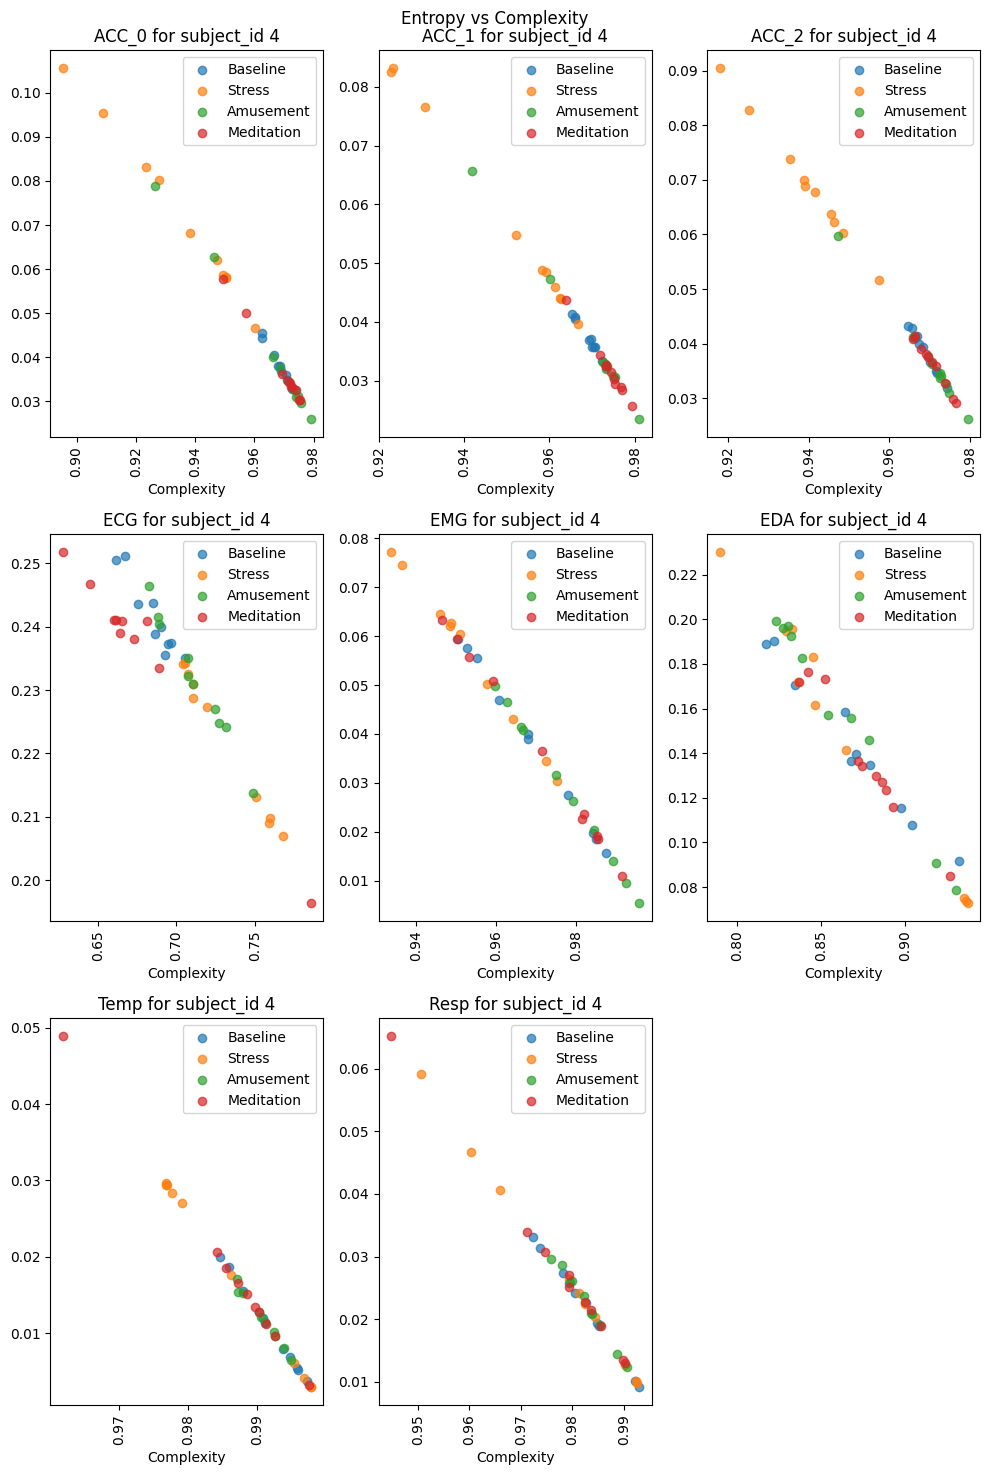

Processing subject_id 6


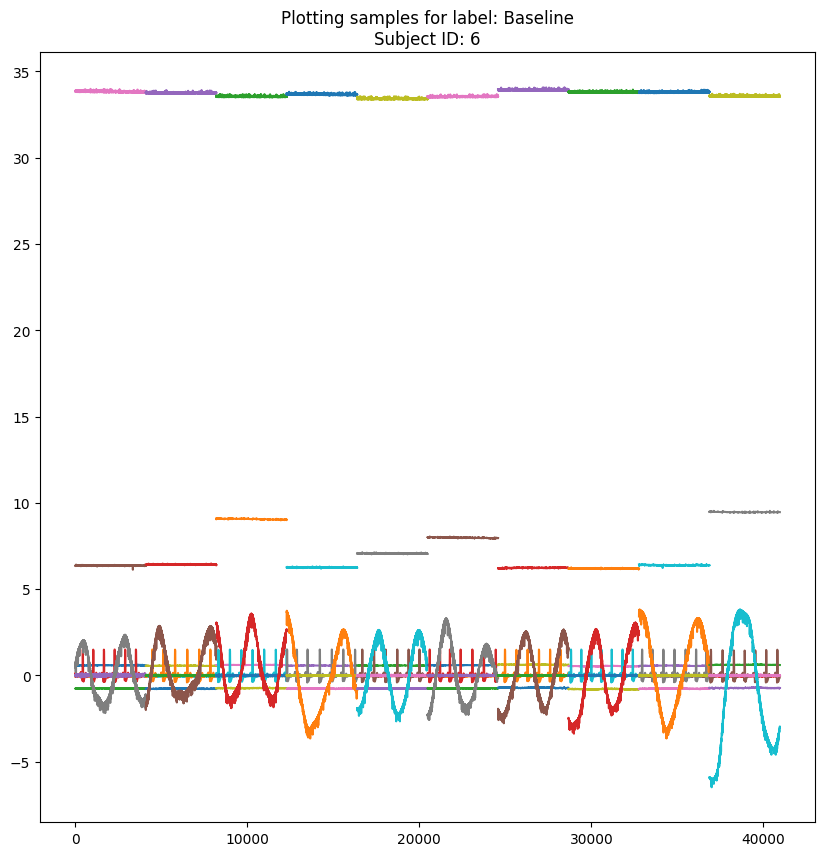

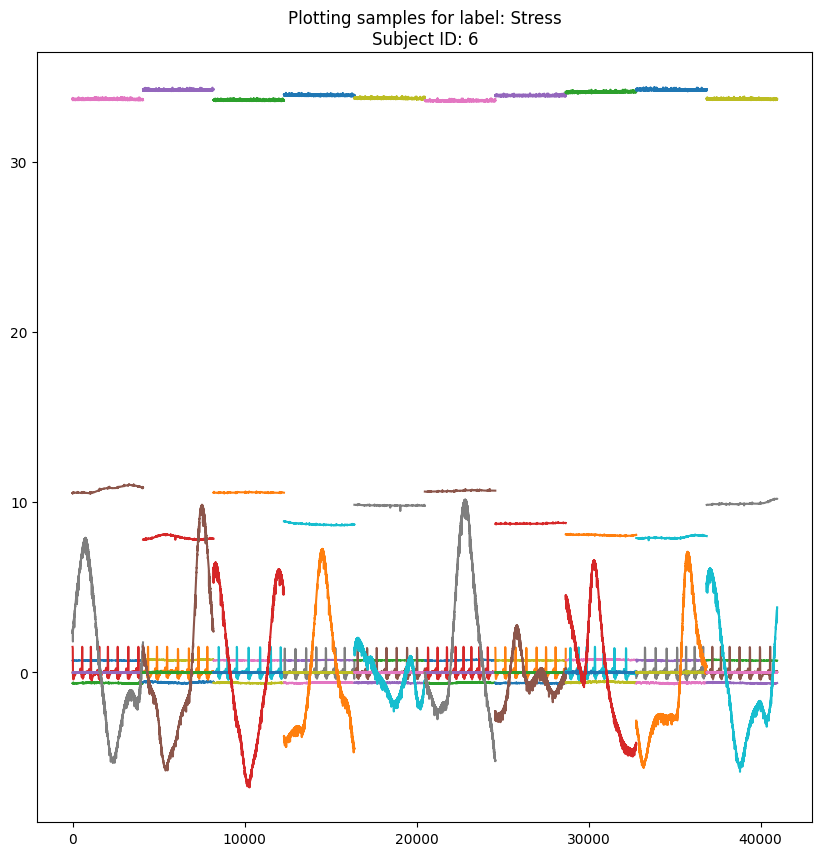

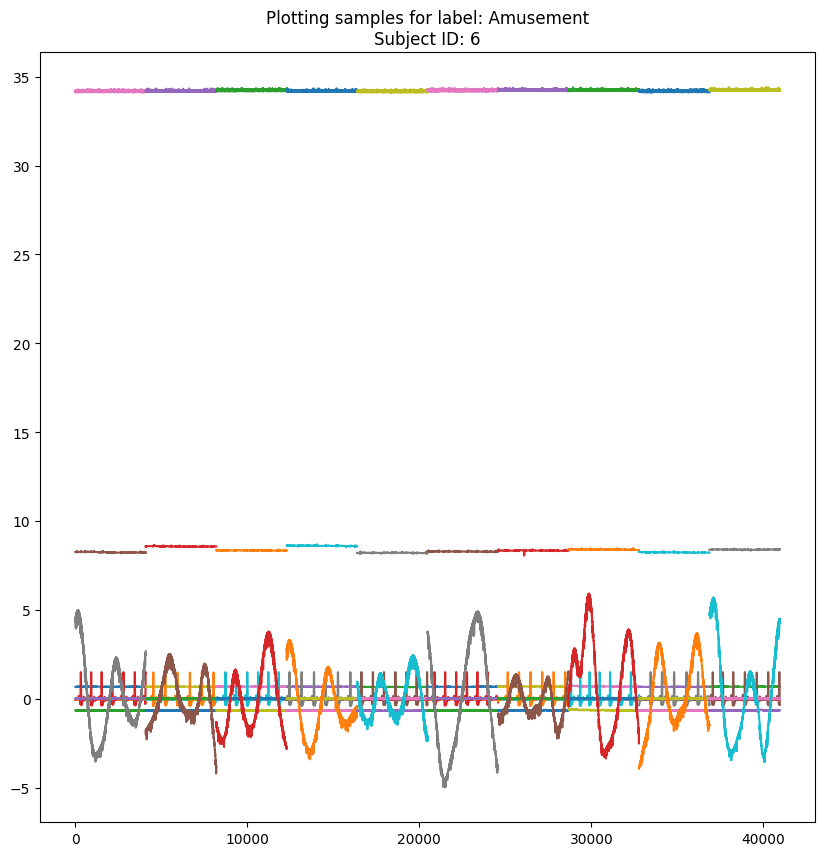

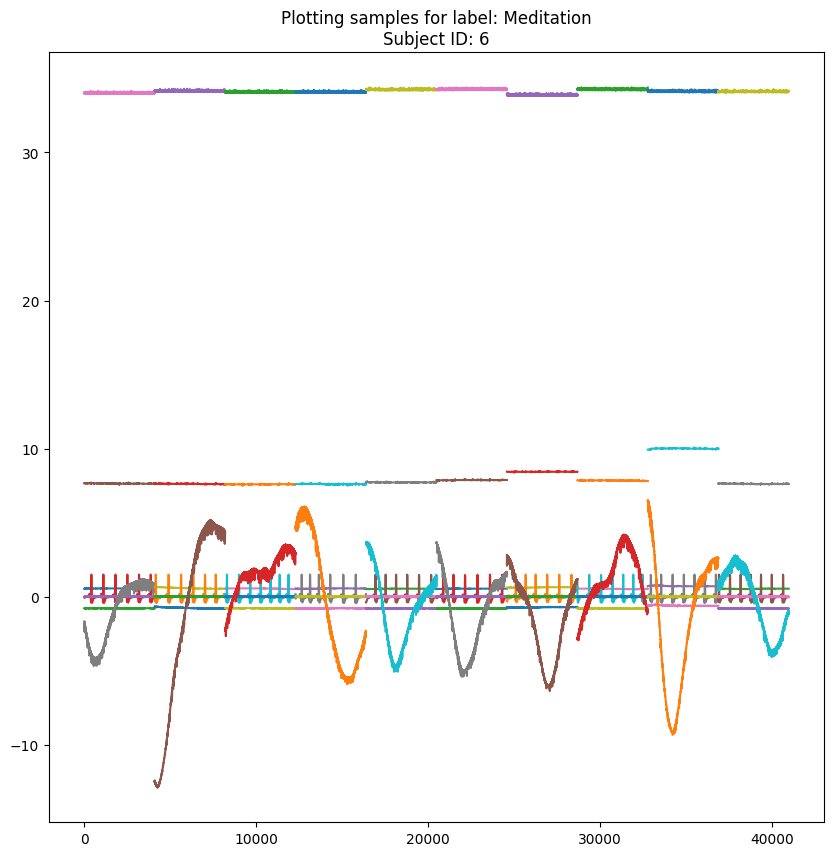

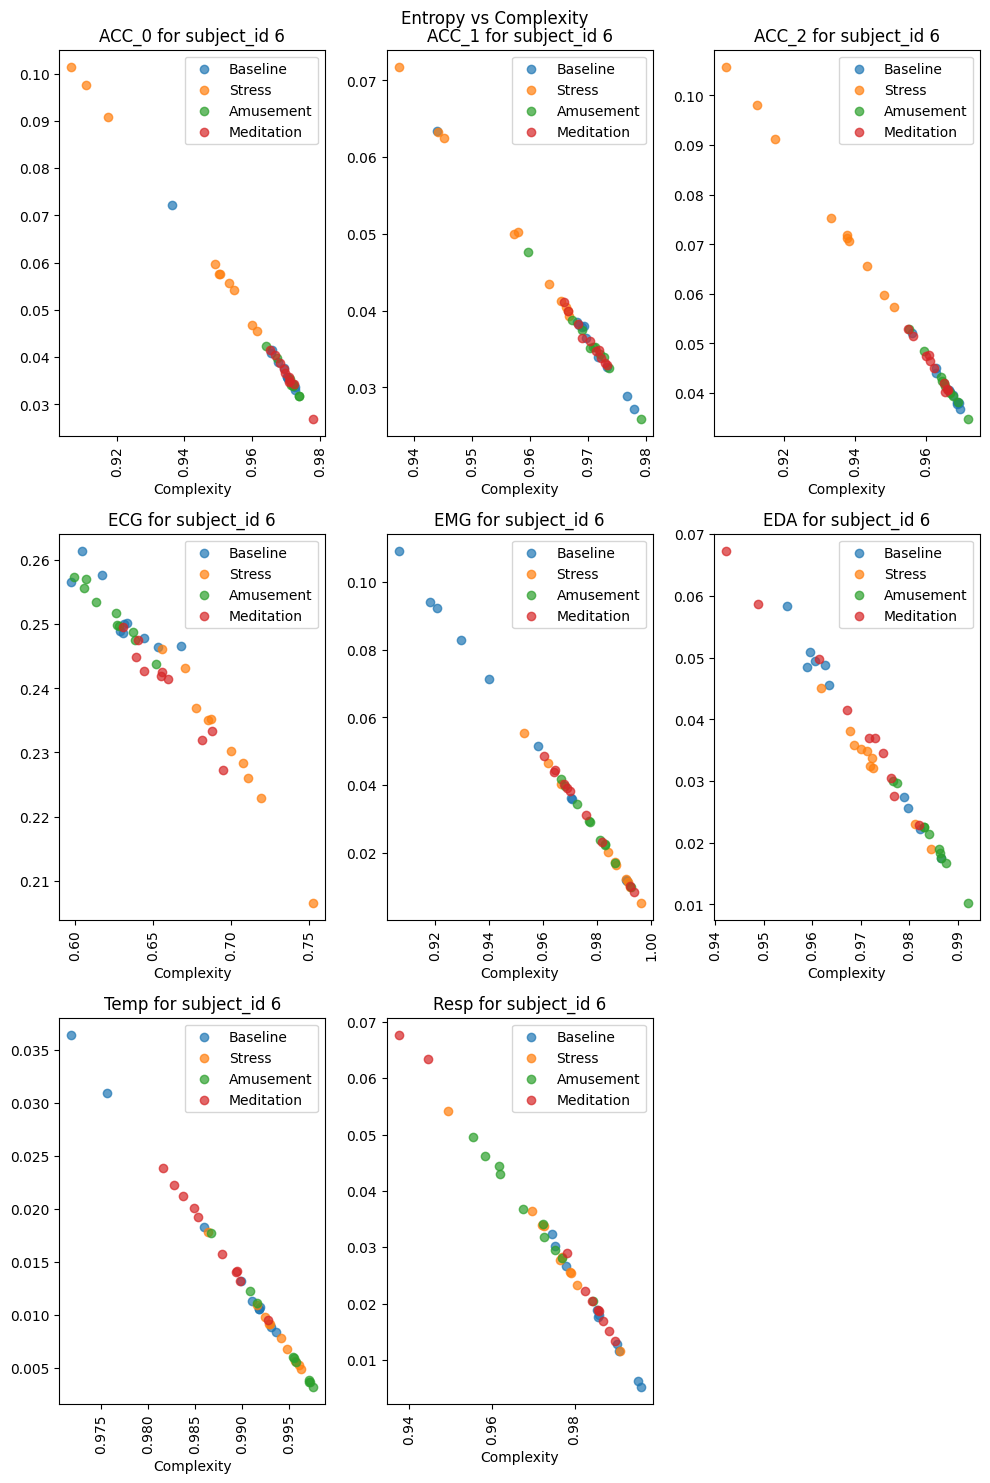

Processing subject_id 8


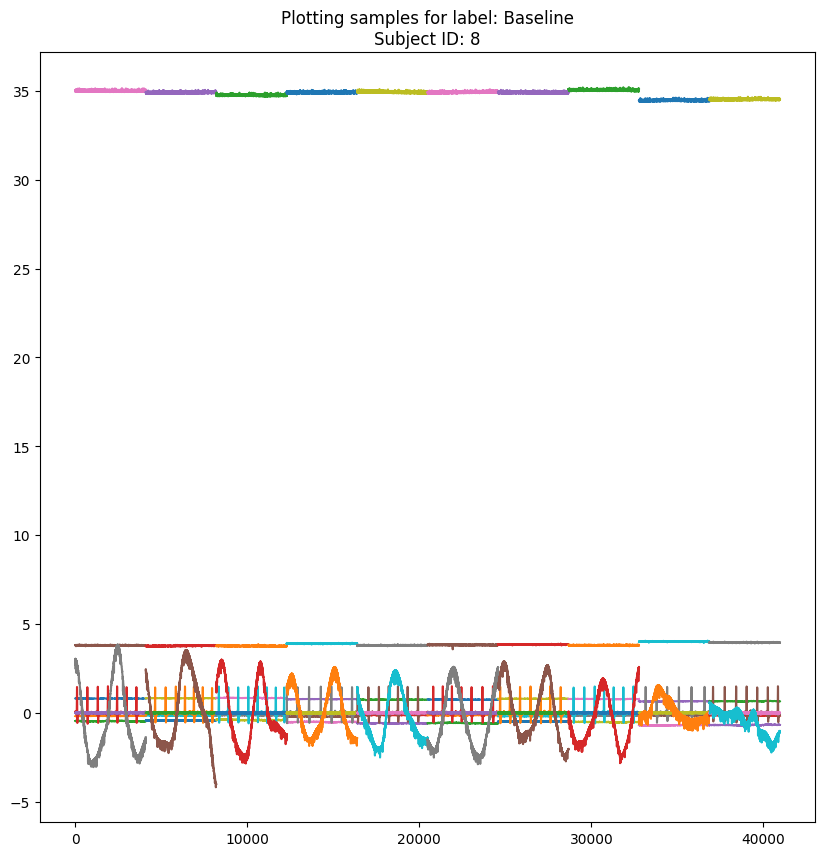

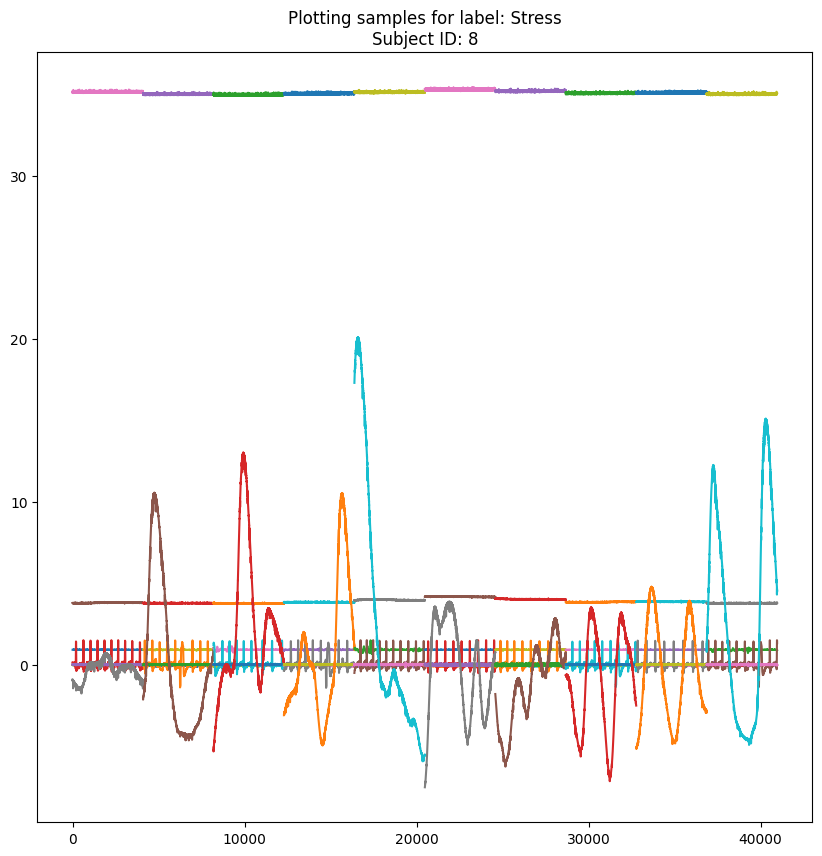

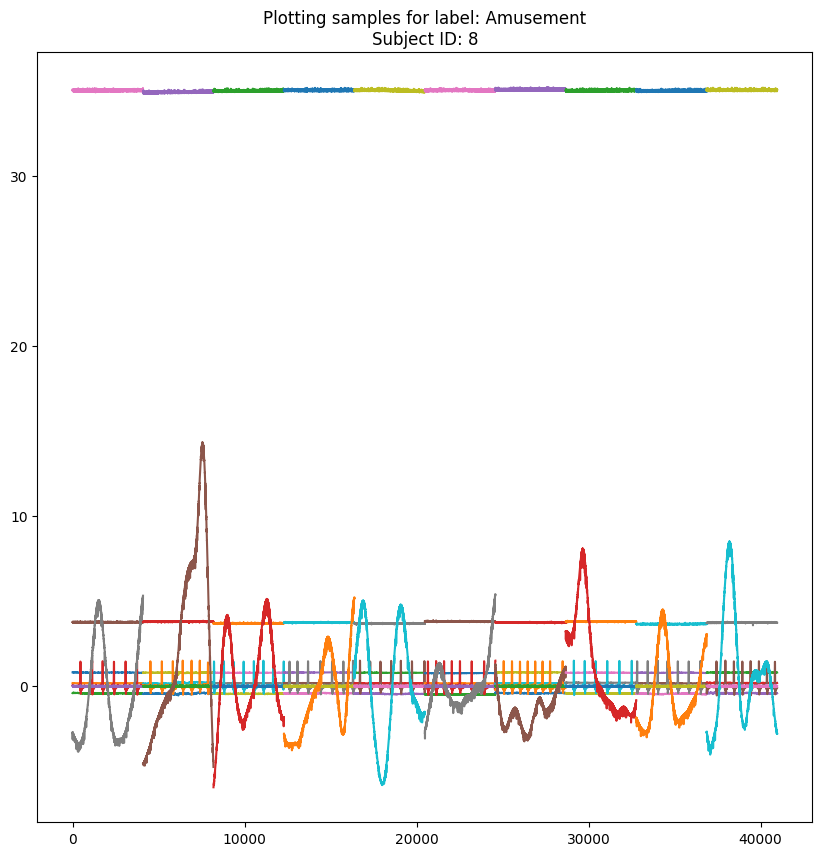

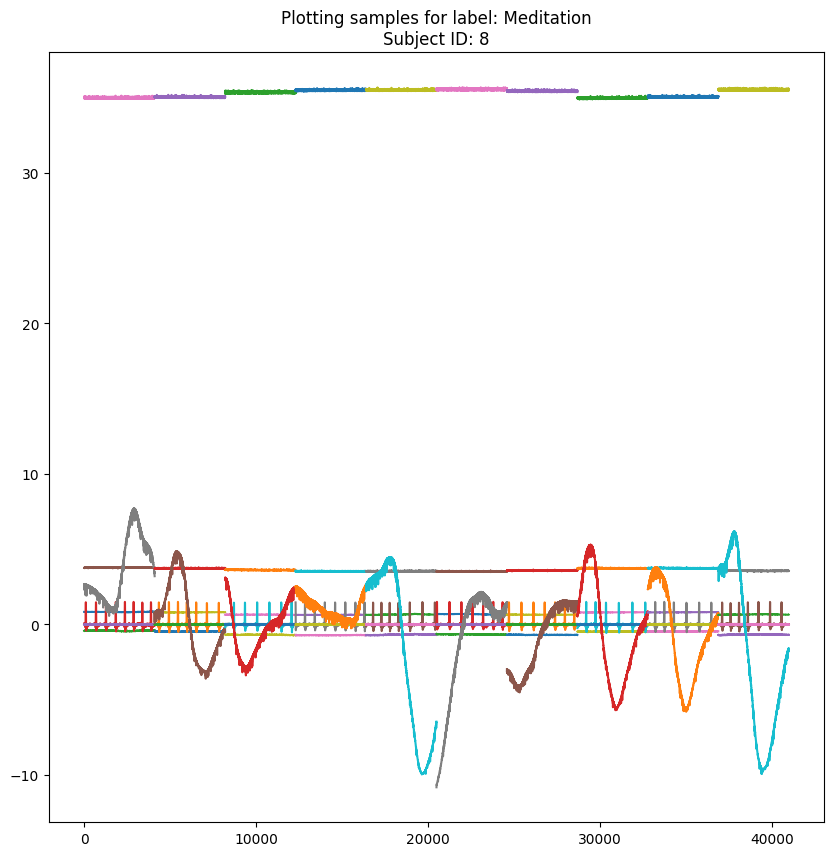

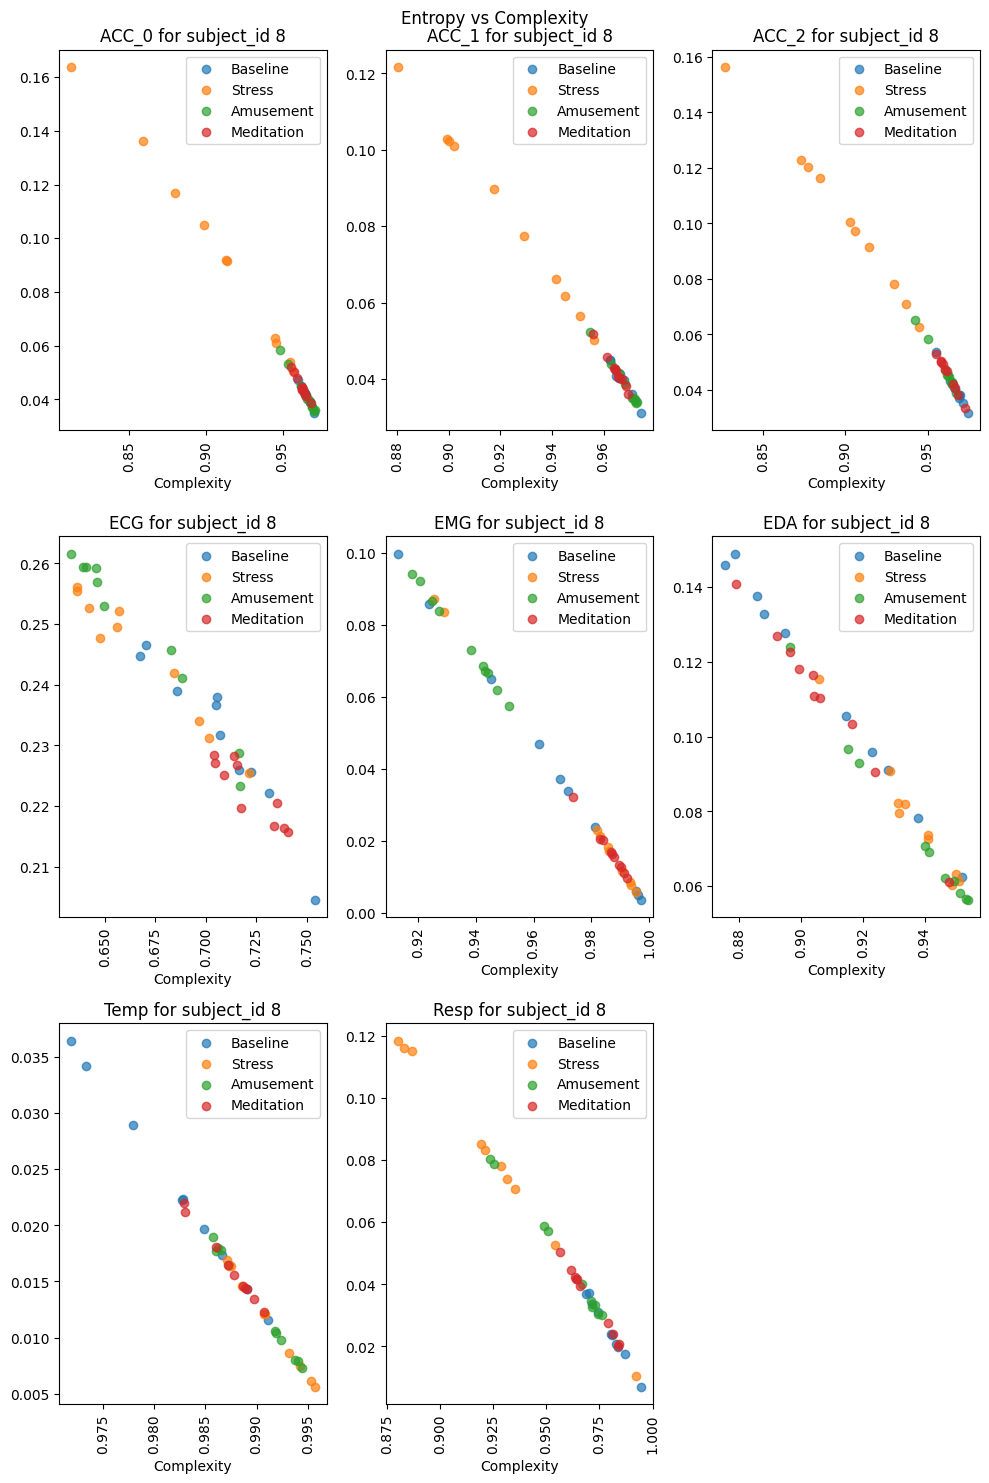

Processing subject_id 10


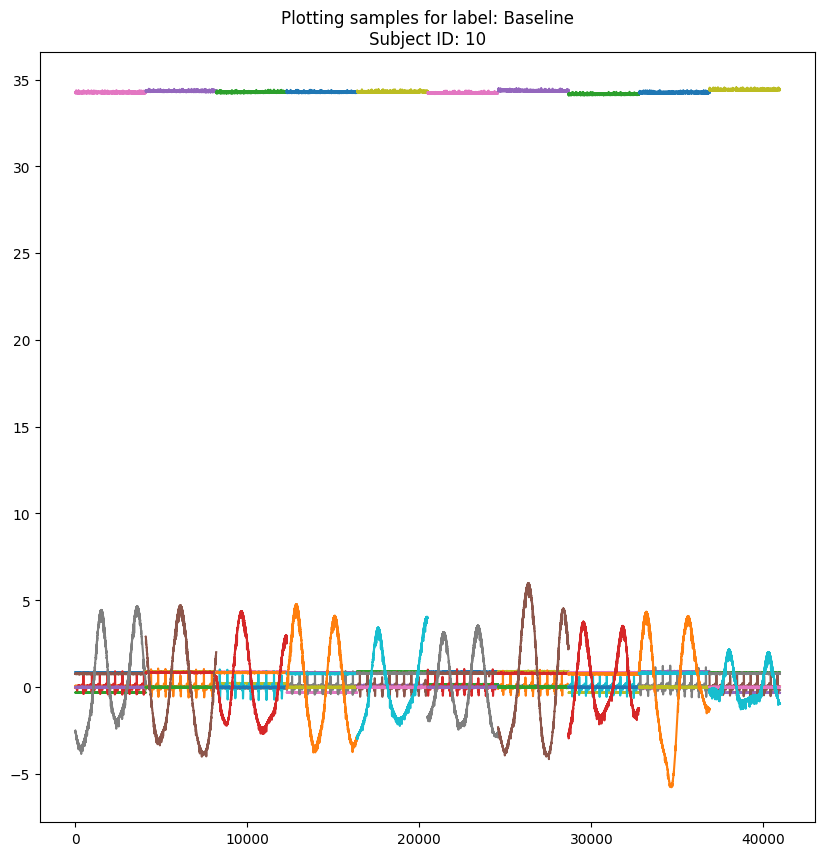

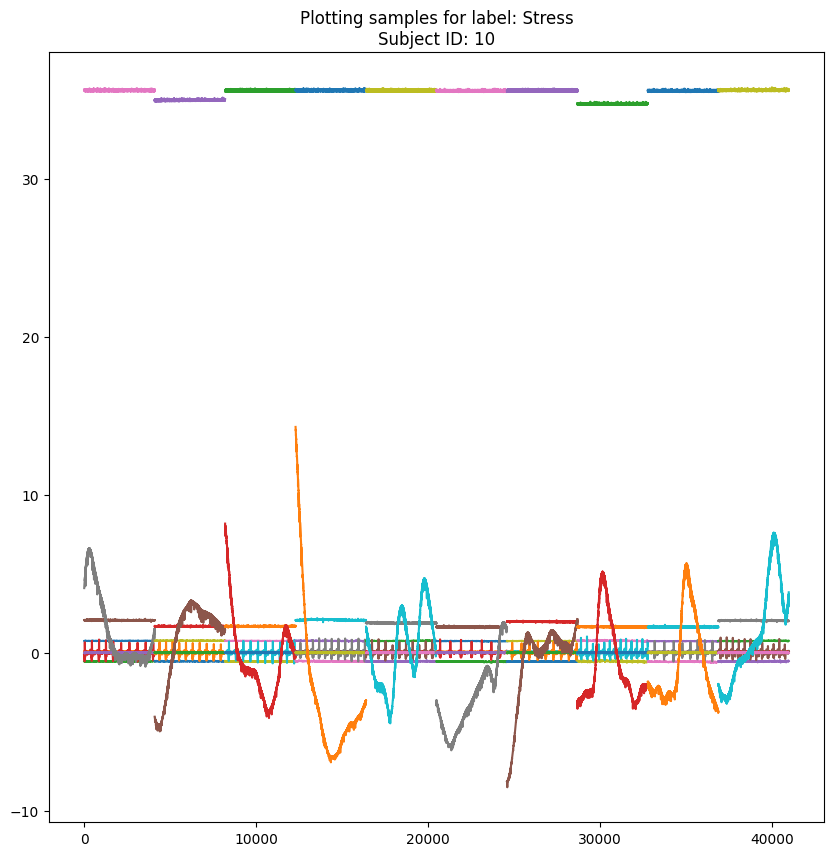

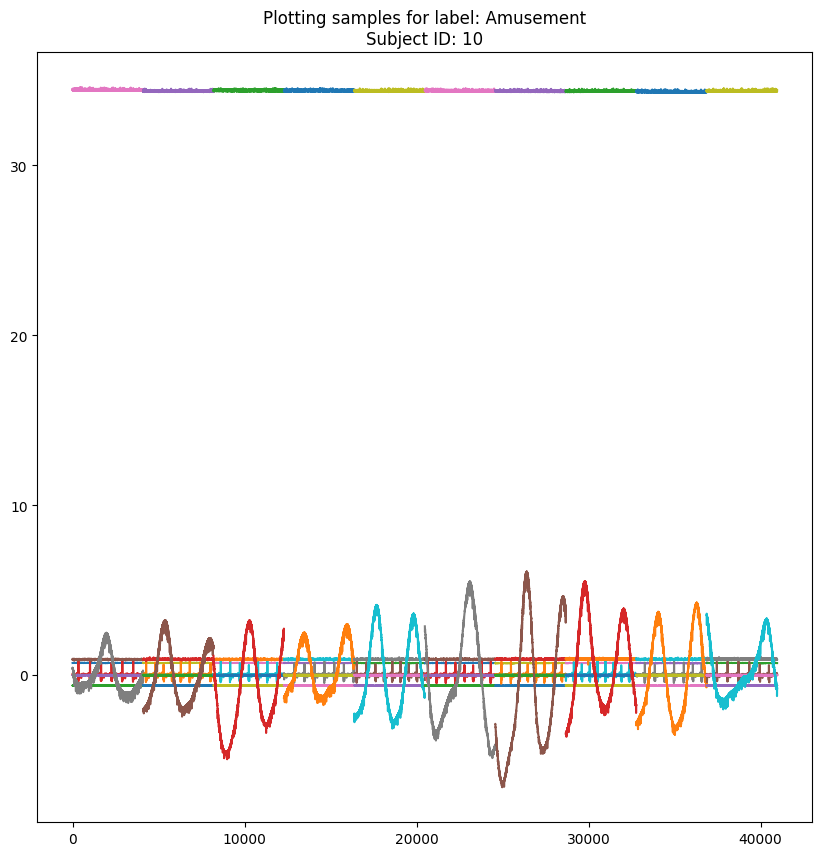

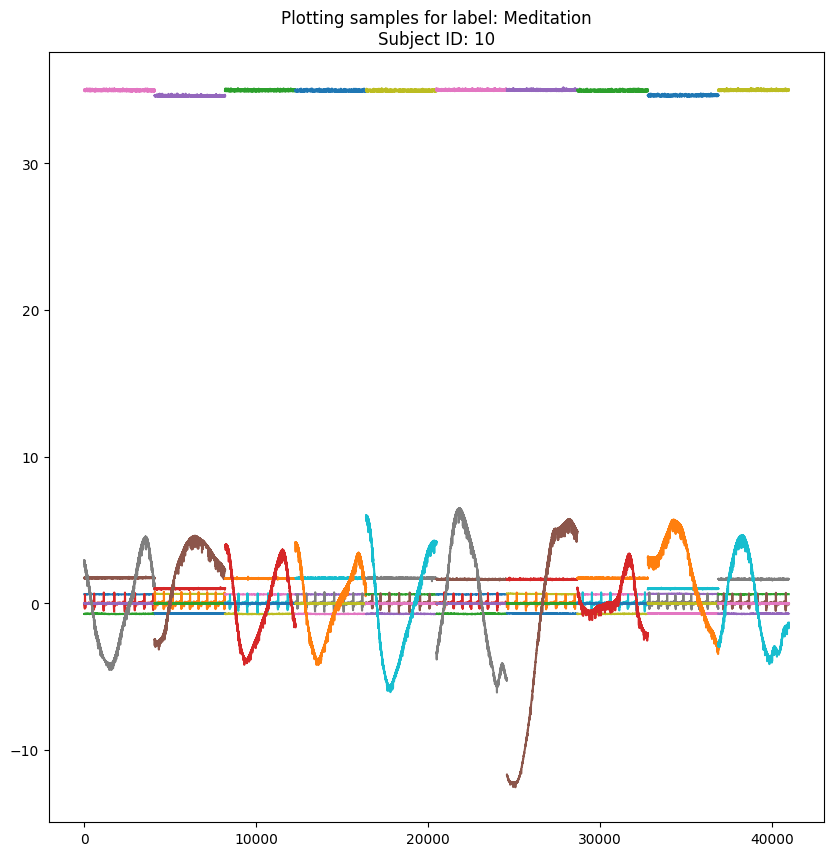

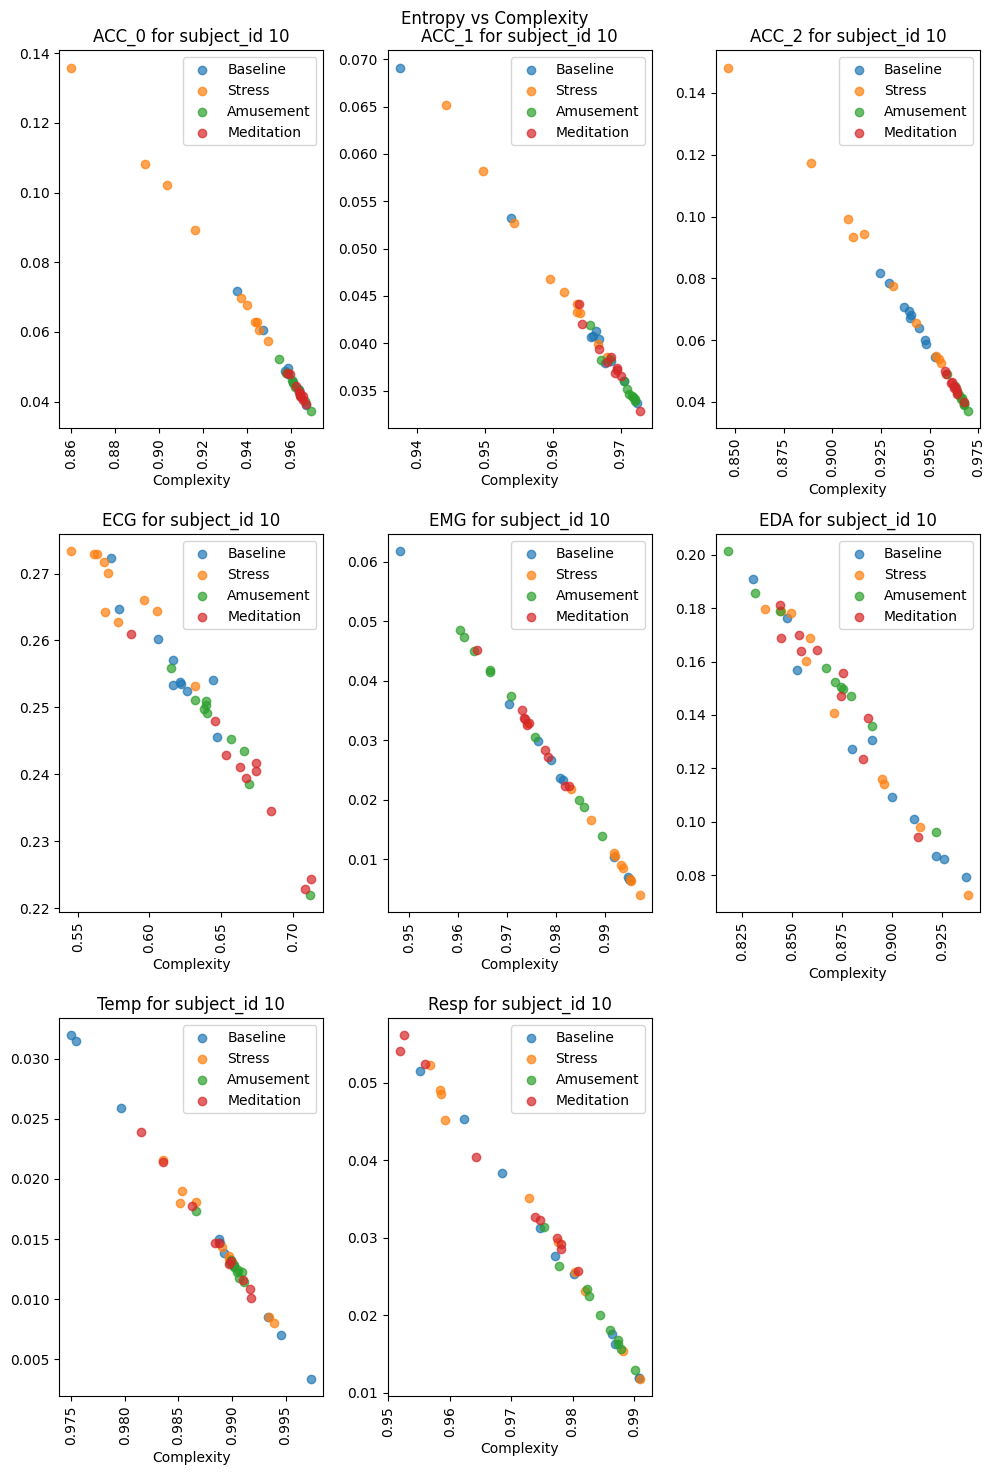

In [12]:
choosen_subject_id = [2, 4, 6, 8, 10]

for subject_id in choosen_subject_id:
    print("Processing subject_id", subject_id)
    data = load_data(subject_id)
    # print(data["signal"]["chest"].keys())

    labeled_dict = extract_samples(data)
    # print(labeled_dict.keys())

    samples_choosen = choose_samples_and_plot(labeled_dict, subject_id)
    pe_dict, complexity_dict = find_pe_complexity_for_all_samples(labeled_dict, samples_choosen)

    plot_pe_complexity(pe_dict, complexity_dict, state_labels, subject_id)